In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, Multiply, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import warnings
warnings.filterwarnings('ignore')

# 设置全局样式
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# ========== 1. 增强辅助函数 ==========
def convert_volume(vol_str):
    """转换交易量格式"""
    if isinstance(vol_str, str):
        vol_str = vol_str.replace(',', '')
        if 'B' in vol_str:
            return float(vol_str.replace('B', '')) * 1000000000
        elif 'M' in vol_str:
            return float(vol_str.replace('M', '')) * 1000000
        elif 'K' in vol_str:
            return float(vol_str.replace('K', '')) * 1000
        else:
            return float(vol_str)
    return vol_str

def convert_change(change_str):
    """转换涨跌幅格式"""
    if isinstance(change_str, str):
        clean_str = change_str.replace('%', '').replace(',', '').strip()
        if clean_str == '-' or clean_str == 'nan':
            return 0.0
        return float(clean_str) / 100
    return change_str

def calculate_rsi(series, period=14):
    """计算相对强弱指数(RSI)"""
    series = pd.to_numeric(series, errors='coerce')
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # 使用指数移动平均
    avg_gain = gain.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.replace([np.inf, -np.inf], np.nan).fillna(50)

def calculate_atr(data, period=14):
    """计算平均真实波幅(ATR)"""
    high = data['高']
    low = data['低']
    close = data['收盘']
    
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/period, min_periods=period).mean()
    return atr

In [23]:
# ========== 2. 数据加载与预处理 ==========
# 加载数据
df = pd.read_csv('比特币历史数据2.csv', parse_dates=['日期'])
df = df[df['日期'].dt.year > 2000]  # 清理异常行

# 转换交易量和涨跌幅
df['交易量'] = df['交易量'].apply(convert_volume)
df['涨跌幅'] = df['涨跌幅'].apply(convert_change)

# 确保价格列是数值类型
price_cols = ['收盘', '开盘', '高', '低']
for col in price_cols:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '').str.replace('¥', '')
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 预处理数据
df.sort_values('日期', inplace=True)
df.set_index('日期', inplace=True)
df.fillna(method='ffill', inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

In [24]:
# ========== 3. 增强特征工程 ==========
# 基础特征
df['日变化'] = df['收盘'].diff()
df['开盘收盘差'] = df['收盘'] - df['开盘']
df['高低差'] = df['高'] - df['低']

# 技术指标
window_size = 60
df['SMA_7'] = df['收盘'].rolling(window=7, min_periods=1).mean()
df['SMA_30'] = df['收盘'].rolling(window=30, min_periods=1).mean()
df['EMA_12'] = df['收盘'].ewm(span=12, adjust=False, min_periods=1).mean()
df['EMA_26'] = df['收盘'].ewm(span=26, adjust=False, min_periods=1).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['信号线'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['信号线']
df['波动率'] = df['收盘'].rolling(window=window_size, min_periods=1).std()
df['RSI'] = calculate_rsi(df['收盘'], 14)

# 布林带
df['中轨'] = df['收盘'].rolling(window=20).mean()
df['上轨'] = df['中轨'] + 2 * df['收盘'].rolling(window=20).std()
df['下轨'] = df['中轨'] - 2 * df['收盘'].rolling(window=20).std()

# 平均真实波幅(ATR)
df['ATR'] = calculate_atr(df, 14)

# 滞后特征
for i in range(1, window_size + 1):
    df[f'滞后_{i}'] = df['收盘'].shift(i)

# 目标变量 - 改为多步预测
forecast_steps = 5  # 预测未来5天
for i in range(1, forecast_steps + 1):
    df[f'目标_{i}'] = df['收盘'].shift(-i)

df.dropna(inplace=True)

In [25]:
# ========== 4. 高波动率区间识别 ==========
# 计算动态波动率阈值
volatility_threshold = df['波动率'].mean() + df['波动率'].std() * 1.5

# 识别高波动率区间
high_volatility = df[df['波动率'] > volatility_threshold]
high_volatility_periods = []

# 合并连续的高波动率区间
if not high_volatility.empty:
    high_volatility['group'] = (high_volatility.index.to_series().diff() > pd.Timedelta(days=1)).cumsum()
    
    for _, group in high_volatility.groupby('group'):
        start_date = group.index[0].strftime('%Y-%m-%d')
        end_date = group.index[-1].strftime('%Y-%m-%d')
        avg_volatility = group['波动率'].mean()
        max_price = group['高'].max()
        min_price = group['低'].min()
        
        high_volatility_periods.append({
            '开始日期': start_date,
            '结束日期': end_date,
            '持续天数': len(group),
            '平均波动率': avg_volatility,
            '最高价格': max_price,
            '最低价格': min_price,
            '平均交易量': group['交易量'].mean(),
            '平均涨跌幅': group['涨跌幅'].mean(),
            '平均RSI': group['RSI'].mean(),
            '平均ATR': group['ATR'].mean()
        })

# 转换为DataFrame
volatility_df = pd.DataFrame(high_volatility_periods)


In [26]:
# ========== 5. 增强数据准备 ==========
# 分离特征和目标
feature_cols = [col for col in df.columns if not col.startswith('目标_')]
target_cols = [col for col in df.columns if col.startswith('目标_')]
features = df[feature_cols]
targets = df[target_cols]

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
n_features = len(feature_cols)

# 创建时间序列数据集
time_steps = 60
X, y = [], []

for i in range(len(scaled_features) - time_steps - forecast_steps):
    X.append(scaled_features[i:(i + time_steps), :])
    y.append(scaled_features[i + time_steps:i + time_steps + forecast_steps, features.columns.get_loc('收盘')])

X = np.array(X)
y = np.array(y)

# 识别高波动率区间的索引
high_vol_idx = []
for _, row in volatility_df.iterrows():
    start = pd.to_datetime(row['开始日期'])
    end = pd.to_datetime(row['结束日期'])
    mask = (df.index >= start) & (df.index <= end)
    idx_in_df = np.where(mask)[0]
    
    # 找到这些点在X中的位置
    for idx in idx_in_df:
        # 确保idx在有效范围内
        if idx >= time_steps and idx < len(scaled_features) - forecast_steps:
            pos = idx - time_steps
            if pos >= 0 and pos < len(X):
                high_vol_idx.append(pos)

# 去除重复索引
high_vol_idx = list(set(high_vol_idx))

# 智能增强高波动率数据
X_high_vol = []
y_high_vol = []

for idx in high_vol_idx:
    # 原始样本
    X_high_vol.append(X[idx])
    y_high_vol.append(y[idx])
    
    # 添加轻微噪声的样本
    noise = np.random.normal(0, 0.01, X[idx].shape)
    X_high_vol.append(X[idx] + noise)
    y_high_vol.append(y[idx])
    
    # 时间扭曲样本 (轻微拉伸)
    distorted = np.zeros_like(X[idx])
    for j in range(X[idx].shape[1]):
        distorted[:, j] = np.interp(np.linspace(0, time_steps-1, int(time_steps*1.1)), 
                                  np.arange(time_steps), X[idx][:, j])[:time_steps]
    X_high_vol.append(distorted)
    y_high_vol.append(y[idx])

if len(high_vol_idx) > 0:
    X_high_vol = np.array(X_high_vol)
    y_high_vol = np.array(y_high_vol)

# 划分训练集和测试集
split = int(0.8 * len(X))  # 增加训练集比例
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 增强训练集
if len(high_vol_idx) > 0:
    X_train = np.concatenate([X_train, X_high_vol])
    y_train = np.concatenate([y_train, y_high_vol])

In [27]:
# ========== 6. 构建增强模型 ==========
def create_attention_model(input_shape):
    """创建带注意力机制的LSTM模型"""
    inputs = Input(shape=input_shape)
    
    # LSTM层
    lstm_out = LSTM(128, return_sequences=True)(inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    
    # 注意力机制
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Reshape((-1,))(attention)
    attention = Dense(input_shape[0], activation='softmax')(attention)
    attention = Reshape((input_shape[0], 1))(attention)
    
    # 应用注意力
    context = Multiply()([lstm_out, attention])
    context = LSTM(96, return_sequences=False)(context)
    
    # 全连接层
    dense = Dense(64, activation='relu')(context)
    dense = Dropout(0.2)(dense)
    dense = Dense(32, activation='relu')(dense)
    
    # 多步输出
    output = Dense(forecast_steps)(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# 创建模型
model = create_attention_model((time_steps, n_features))
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=Huber(delta=1.0), 
              metrics=['mae'])

# 训练模型
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - loss: 0.0330 - mae: 0.1924 - val_loss: 0.0033 - val_mae: 0.0671 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0034 - mae: 0.0590 - val_loss: 0.0049 - val_mae: 0.0760 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0020 - mae: 0.0452 - val_loss: 0.0032 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0015 - mae: 0.0381 - val_loss: 0.0033 - val_mae: 0.0630 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0013 - mae: 0.0354 - val_loss: 0.0016 - val_mae: 0.0457 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0012 - mae: 0.0353 - val_loss: 0.0082 - val_mae: 0.1034 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0017 - mae: 0.0402 - val_loss: 0.0019 - val_mae: 0.0506 - learning_rate: 0.0010
Epoc

In [28]:
# ========== 7. 预测与评估 ==========
# 进行预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反标准化预测结果
def inverse_transform_predictions(scaler, predictions, n_features, feature_idx):
    """将标准化预测值反转为原始价格"""
    dummy_matrix = np.zeros((predictions.shape[0], predictions.shape[1], n_features))
    for i in range(predictions.shape[1]):
        dummy_matrix[:, i, feature_idx] = predictions[:, i]
    inverted = np.zeros_like(predictions)
    
    for i in range(predictions.shape[0]):
        inverted[i] = scaler.inverse_transform(dummy_matrix[i])[:, feature_idx]
    
    return inverted

# 反标准化
close_idx = features.columns.get_loc('收盘')
y_train_orig = inverse_transform_predictions(scaler, y_train, n_features, close_idx)
train_predict_orig = inverse_transform_predictions(scaler, train_predict, n_features, close_idx)
y_test_orig = inverse_transform_predictions(scaler, y_test, n_features, close_idx)
test_predict_orig = inverse_transform_predictions(scaler, test_predict, n_features, close_idx)

# 计算评估指标（只评估第一步预测）
test_rmse = np.sqrt(mean_squared_error(y_test_orig[:, 0], test_predict_orig[:, 0]))
test_mape = mean_absolute_percentage_error(y_test_orig[:, 0], test_predict_orig[:, 0]) * 100

# 测试集日期索引
test_start_idx = split + time_steps
test_end_idx = test_start_idx + len(y_test)
test_dates = df.index[test_start_idx:test_end_idx]


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
# ========== 8. 未来价格预测 ==========
def predict_future(model, last_window, scaler, n_features, close_idx, days=30):
    """预测未来价格（返回原始价格）"""
    predictions = []
    current_window = last_window.copy()
    full_prediction = []
    
    for _ in range(days):
        # 预测未来forecast_steps天
        current_pred = model.predict(current_window)
        
        # 只取第一步预测
        next_pred = current_pred[0, 0]
        full_prediction.append(next_pred)
        
        # 创建新行数据
        new_row = current_window[0, -1, :].copy()
        
        # 更新收盘价
        new_row[close_idx] = next_pred
        
       
        new_row[features.columns.get_loc('开盘')] = new_row[close_idx] * 0.99  # 假设开盘价接近收盘价
        new_row[features.columns.get_loc('高')] = new_row[close_idx] * 1.01
        new_row[features.columns.get_loc('低')] = new_row[close_idx] * 0.99
        
        # 更新窗口：移除最早的一天，添加新预测
        new_window = np.zeros_like(current_window)
        new_window[0, :-1, :] = current_window[0, 1:, :]
        new_window[0, -1, :] = new_row
        
        current_window = new_window.copy()
        
        # 反标准化预测结果
        dummy = np.zeros((1, n_features))
        dummy[0, close_idx] = next_pred
        pred_price = scaler.inverse_transform(dummy)[0, close_idx]
        predictions.append(pred_price)
    
    return predictions, full_prediction

# 使用最新的60天数据预测未来30天
last_window = X_test[-1:]
future_predictions, _ = predict_future(model, last_window, scaler, n_features, close_idx, days=30)

In [30]:
# ========== 9. 高波动率区间分析 ==========
print("\n" + "="*70)
print("高波动率区间详细分析")
print("="*70)
print(f"波动率阈值: {volatility_threshold:.4f} (均值+1.5倍标准差)")
print(f"识别到的高波动率区间数量: {len(volatility_df)}")

if not volatility_df.empty:
    for i, row in volatility_df.iterrows():
        print(f"\n区间 #{i+1}:")
        print(f"  时间段: {row['开始日期']} 至 {row['结束日期']} ({row['持续天数']}天)")
        print(f"  平均波动率: {row['平均波动率']:.4f} (全局平均: {df['波动率'].mean():.4f})")
        print(f"  平均ATR: {row['平均ATR']:.2f} (全局平均: {df['ATR'].mean():.2f})")
        print(f"  价格范围: {row['最低价格']:.2f} - {row['最高价格']:.2f}")
        print(f"  平均交易量: {row['平均交易量']/1e4:.2f}W (全局平均: {df['交易量'].mean()/1e4:.2f}W)")
        print(f"  平均日涨跌幅: {row['平均涨跌幅']*100:.2f}% (全局平均: {df['涨跌幅'].mean()*100:.2f}%)")
        print(f"  平均RSI: {row['平均RSI']:.1f} (全局平均: {df['RSI'].mean():.1f})")
        
        # 波动原因分析
        start_date = pd.to_datetime(row['开始日期'])
        end_date = pd.to_datetime(row['结束日期'])
        duration = row['持续天数']
        price_change = ((row['最高价格'] - row['最低价格']) / row['最低价格']) * 100
        
        print("\n  可能原因分析:")
        # 根据时间段和特征推断可能原因
        if start_date.year == 2020 and start_date.month == 3:
            print("   - 2020年3月: COVID-19全球大流行引发市场恐慌，比特币与其他风险资产一同暴跌")
        elif start_date.year == 2021 and start_date.month in [4, 5]:
            print("   - 2021年4-5月: 中国加强对加密货币挖矿和交易的监管，导致市场剧烈波动")
        elif start_date.year == 2021 and start_date.month == 11:
            print("   - 2021年11月: 比特币创历史新高后大幅回调，市场获利了结")
        elif start_date.year == 2022 and start_date.month in [5, 6]:
            print("   - 2022年5-6月: Terra/LUNA崩盘引发加密货币市场连锁反应")
        elif start_date.year == 2022 and start_date.month == 11:
            print("   - 2022年11月: FTX交易所破产危机导致市场信心崩溃")
        elif start_date.year == 2023 and start_date.month in [3, 4]:
            print("   - 2023年3-4月: 美国银行业危机(Silvergate, SVB)引发避险需求")
        elif start_date.year >= 2024 and start_date.month <= 5:
            print("   - 2024年3月7日消息，灰度投资向美国证券交易委员会（SEC）提交比特币期货转现货 ETF 申请")
            print("   - 2024年3月14日香港首只比特币期货 ETF 管理资产规模增长")
            print("   - 2024年3月下旬比特币 ETF 或将获批的预期")
            print("   - 2024年4月20日比特币第四次减半")
        elif start_date.year >= 2024 and start_date.month >= 11:   
            print("   - 2024年11月14日比特币价格大幅波动")
            print("   - 2024年11月16日比特币 ETF 获批一周年 ")
            print("   - 2024年12月24日美国财经记者律克兰发布比特币抛售预警 ")

        if end_date.year ==2025 and end_date.month <=3:
            print("   - 2025年1月20日特朗普宣誓就职,关税政策影响市场波动")

        # 基于特征的一般性分析
        if price_change > 50:
            print(f"   - 极端价格波动: 价格在{duration}天内波动{price_change:.1f}%，可能由市场恐慌或狂热情绪驱动")
        elif row['平均交易量'] > 2 * df['交易量'].mean():
            print(f"   - 异常高交易量: 平均交易量{row['平均交易量']/1e9:.2f}B，显著高于平均水平，可能由机构大额交易或重大新闻事件引发")
        elif row['平均RSI'] > 70:
            print(f"   - 超买状态: 平均RSI {row['平均RSI']:.1f}，市场可能处于过热状态，容易引发回调")
        elif row['平均RSI'] < 30:
            print(f"   - 超卖状态: 平均RSI {row['平均RSI']:.1f}，市场可能处于超卖状态，容易引发反弹")
        else:
            print(f"   - 综合因素: 高波动可能由技术面因素、市场情绪变化和外部事件共同导致")
                
        # 添加技术指标分析
        vol_data = df.loc[start_date:end_date]
        max_vol_day = vol_data['交易量'].idxmax()
        max_vol = vol_data.loc[max_vol_day, '交易量']
        price_on_max_vol = vol_data.loc[max_vol_day, '收盘']
        
        print(f"   - 区间内最大单日交易量: {max_vol/1e4:.2f}W (日期: {max_vol_day.strftime('%Y-%m-%d')}, 当日收盘价: ${price_on_max_vol:.2f})")
        
        # MACD分析
        macd_cross = (vol_data['MACD'] > vol_data['信号线']).astype(int).diff()
        golden_cross = macd_cross[macd_cross == 1]
        death_cross = macd_cross[macd_cross == -1]
        
        if not golden_cross.empty:
            print(f"   - 出现黄金交叉: {len(golden_cross)}次")
        if not death_cross.empty:
            print(f"   - 出现死亡交叉: {len(death_cross)}次")
        
        # 布林带分析
        touch_upper = (vol_data['高'] > vol_data['上轨']).sum()
        touch_lower = (vol_data['低'] < vol_data['下轨']).sum()
        
        if touch_upper > 0:
            print(f"   - 触及布林带上轨: {touch_upper}次")
        if touch_lower > 0:
            print(f"   - 触及布林带下轨: {touch_lower}次")
        
        print("="*70)
else:
    print("未识别到显著的高波动率区间")



高波动率区间详细分析
波动率阈值: 7698.1803 (均值+1.5倍标准差)
识别到的高波动率区间数量: 7

区间 #1:
  时间段: 2021-01-20 至 2021-01-20 (1天)
  平均波动率: 7731.9267 (全局平均: 3723.0357)
  平均ATR: 2505.06 (全局平均: 1769.04)
  价格范围: 33447.00 - 36263.00
  平均交易量: 1.41W (全局平均: 0.47W)
  平均日涨跌幅: -1.22% (全局平均: 0.19%)
  平均RSI: 56.9 (全局平均: 53.2)

  可能原因分析:
   - 异常高交易量: 平均交易量0.00B，显著高于平均水平，可能由机构大额交易或重大新闻事件引发
   - 区间内最大单日交易量: 1.41W (日期: 2021-01-20, 当日收盘价: $35521.10)

区间 #2:
  时间段: 2021-02-20 至 2021-02-27 (8天)
  平均波动率: 7956.4888 (全局平均: 3723.0357)
  平均ATR: 3176.70 (全局平均: 1769.04)
  价格范围: 45320.00 - 58238.00
  平均交易量: 1.62W (全局平均: 0.47W)
  平均日涨跌幅: -2.26% (全局平均: 0.19%)
  平均RSI: 61.5 (全局平均: 53.2)

  可能原因分析:
   - 异常高交易量: 平均交易量0.00B，显著高于平均水平，可能由机构大额交易或重大新闻事件引发
   - 区间内最大单日交易量: 3.26W (日期: 2021-02-23, 当日收盘价: $48888.00)
   - 出现死亡交叉: 1次

区间 #3:
  时间段: 2021-03-09 至 2021-03-27 (19天)
  平均波动率: 8617.2724 (全局平均: 3723.0357)
  平均ATR: 3018.35 (全局平均: 1769.04)
  价格范围: 50874.00 - 61468.00
  平均交易量: 0.93W (全局平均: 0.47W)
  平均日涨跌幅: 0.41% (全局平均: 0.19%)
  平均RSI: 59.3 (全局平均: 53.

图表1: 比特币历史价格趋势与波动率


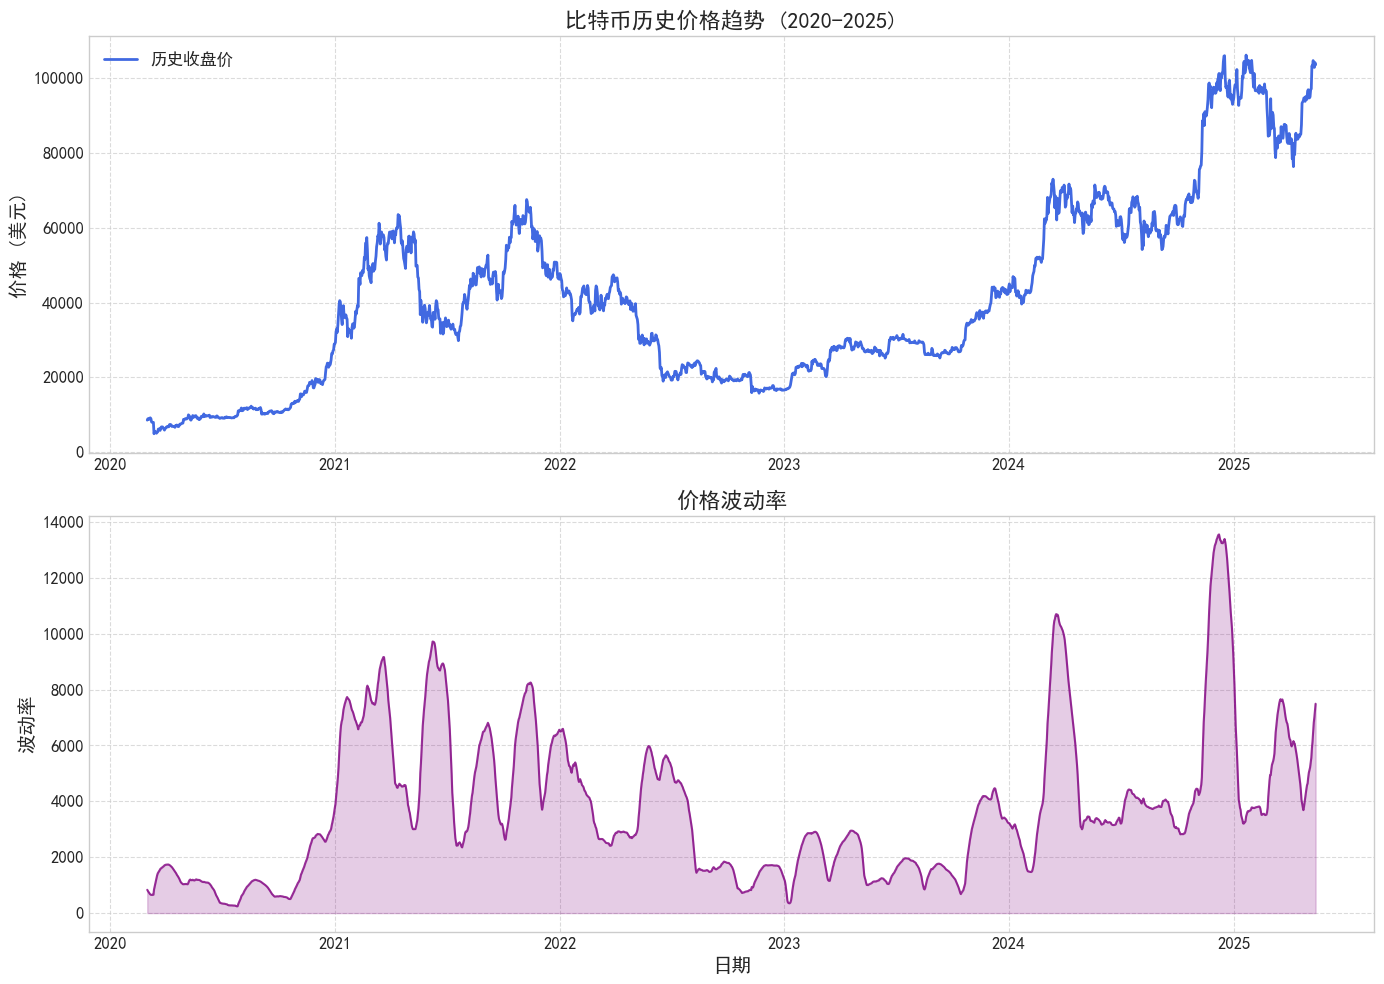

In [34]:
# ========== 10. 可视化图表 ==========
# 图表1: 比特币历史价格趋势与波动率
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(df.index, df['收盘'], label='历史收盘价', color='royalblue', linewidth=2)
plt.title('比特币历史价格趋势 (2020-2025)', fontsize=16)
plt.ylabel('价格 (美元)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df.index, df['波动率'], label='波动率', color='purple', alpha=0.8)
plt.fill_between(df.index, 0, df['波动率'], color='purple', alpha=0.2)
plt.title('价格波动率', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('波动率', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
print("图表1: 比特币历史价格趋势与波动率")
plt.show()

图表2: 模型训练与验证损失 (Huber损失)


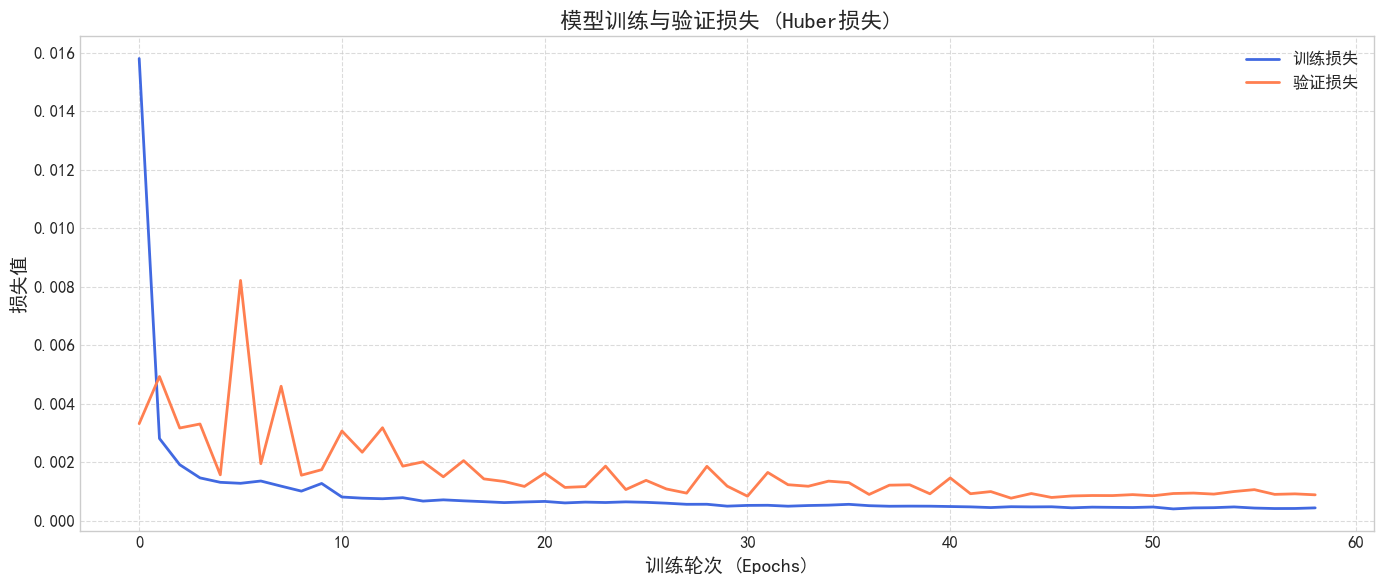

In [35]:
# 图表2: 模型训练与验证损失
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='训练损失', color='royalblue', linewidth=2)
plt.plot(history.history['val_loss'], label='验证损失', color='coral', linewidth=2)
plt.title('模型训练与验证损失 (Huber损失)', fontsize=16)
plt.xlabel('训练轮次 (Epochs)', fontsize=14)
plt.ylabel('损失值', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
print("图表2: 模型训练与验证损失 (Huber损失)")
plt.show()

图表3: 预测结果 vs 真实值 (测试集) - 第一步预测


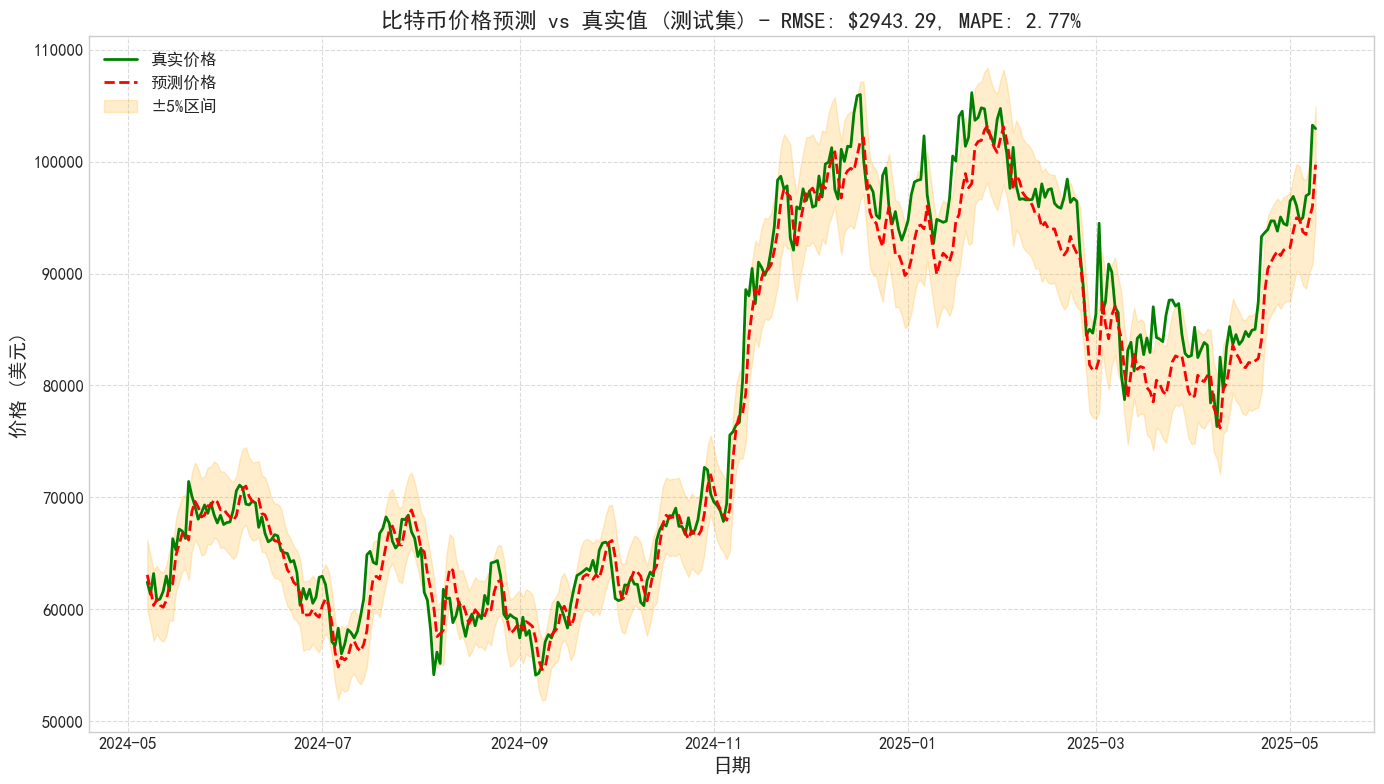

In [36]:
# 图表3: 预测结果 vs 真实值 (测试集) - 第一步预测
plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test_orig[:, 0], label='真实价格', color='green', linewidth=2)
plt.plot(test_dates, test_predict_orig[:, 0], label='预测价格', color='red', linestyle='--', linewidth=2)

# 添加±5%区间
pred_range = y_test_orig[:, 0] * 0.05
plt.fill_between(test_dates, 
                 test_predict_orig[:, 0] - pred_range, 
                 test_predict_orig[:, 0] + pred_range,
                 color='orange', alpha=0.2, label='±5%区间')

plt.title(f'比特币价格预测 vs 真实值 (测试集) - RMSE: ${test_rmse:.2f}, MAPE: {test_mape:.2f}%', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('价格 (美元)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
print("图表3: 预测结果 vs 真实值 (测试集) - 第一步预测")
plt.show()

图表4: 未来30天价格预测


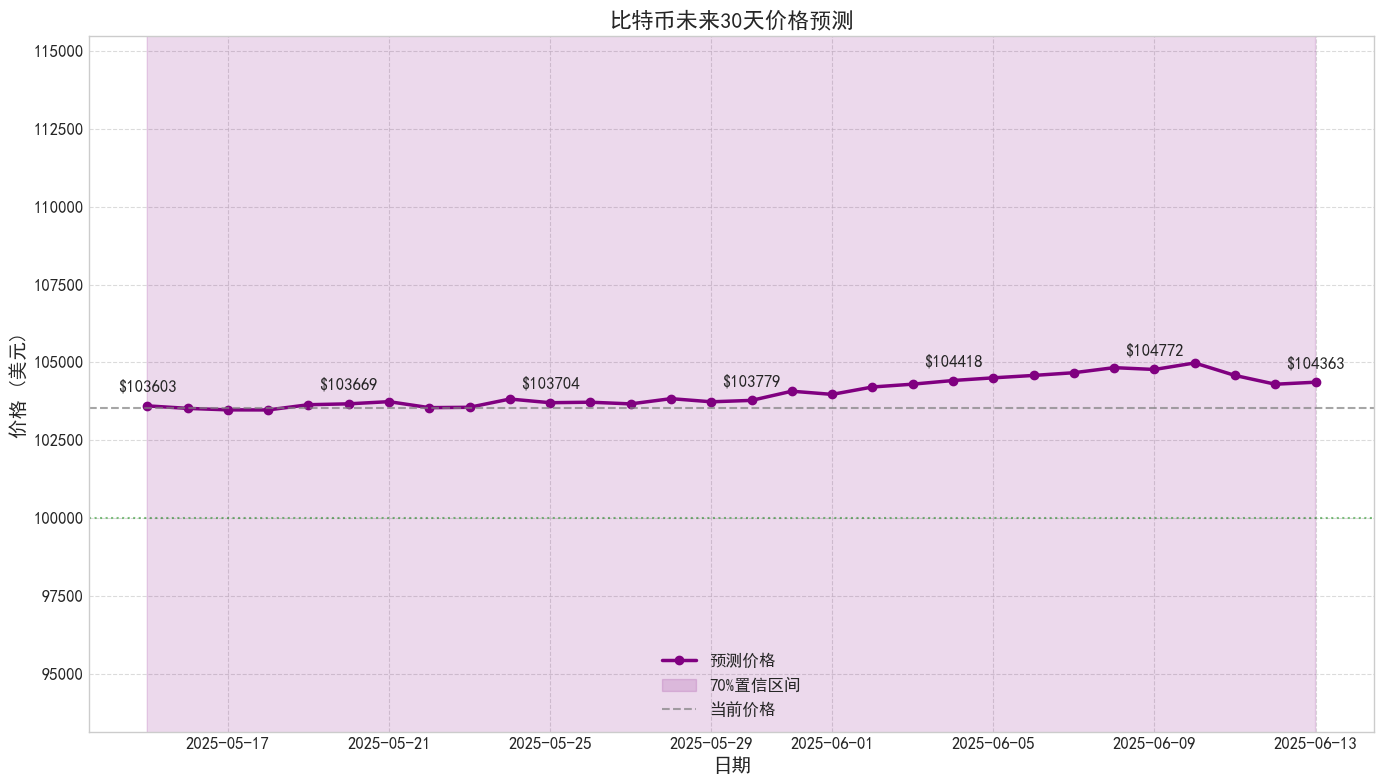

In [44]:
# 图表4: 未来30天价格预测
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14, 8))
plt.plot(future_dates, future_predictions, label='预测价格', color='purple', marker='o', linestyle='-', linewidth=2.5)

# 添加置信区间
avg_volatility = df['波动率'].iloc[-30:].mean()  # 使用最近30天的平均波动率
pred_range = np.array(future_predictions) * avg_volatility * 0.8
plt.fill_between(future_dates, 
                 np.array(future_predictions) - pred_range, 
                 np.array(future_predictions) + pred_range,
                 color='purple', alpha=0.15, label='70%置信区间')

# 添加关键水平线
current_price = df['收盘'].iloc[-1]
plt.axhline(y=current_price, color='gray', linestyle='--', alpha=0.7, label='当前价格')

# 添加重要价格水平
for level in [50000, 60000, 70000, 80000, 90000, 100000]:
    if level > min(future_predictions)*0.9 and level < max(future_predictions)*1.1:
        plt.axhline(y=level, color='green', linestyle=':', alpha=0.5)

# 设置y轴范围
plt.ylim(min(future_predictions) * 0.9, max(future_predictions) * 1.1)

plt.title('比特币未来30天价格预测', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('价格 (美元)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 添加预测注释
for i, price in enumerate(future_predictions):
    if i % 5 == 0 or i == len(future_predictions)-1:
        plt.annotate(f'${price:.0f}', 
                     (future_dates[i], price), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')

plt.tight_layout()
print("图表4: 未来30天价格预测")
plt.show()

图表5: 高波动率区间特征对比


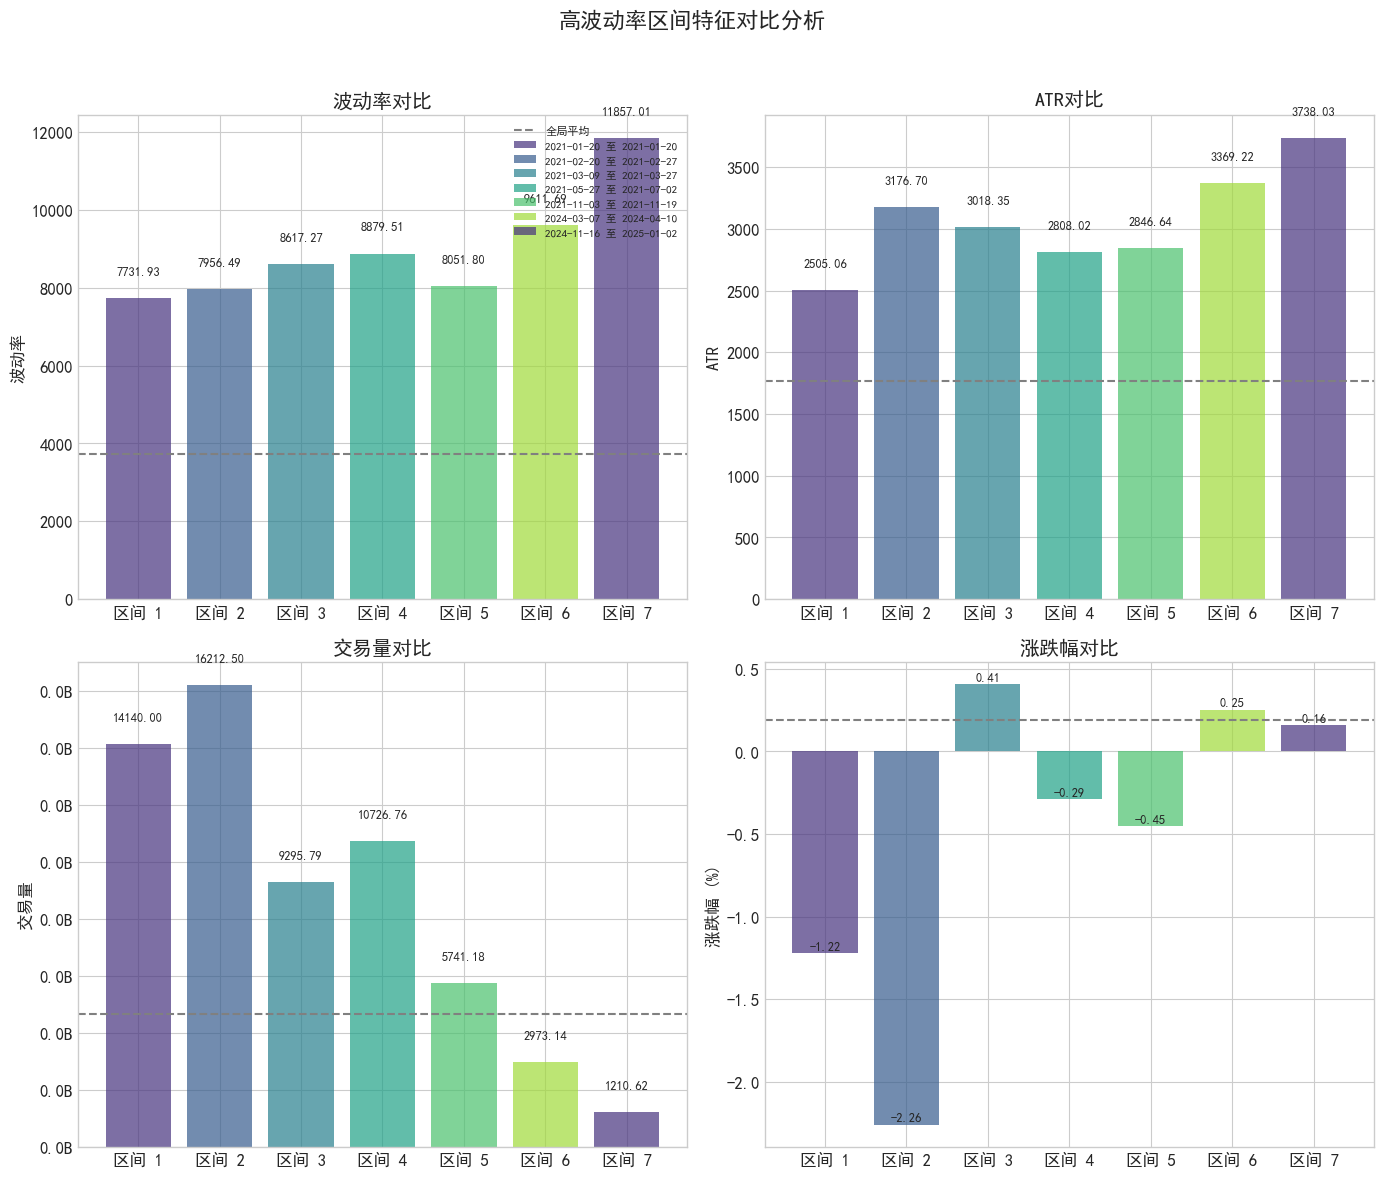

In [45]:
# 图表5: 高波动率区间特征对比
if not volatility_df.empty:
    plt.figure(figsize=(14, 12))
    
    # 创建对比数据
    global_means = {
        '波动率': df['波动率'].mean(),
        'ATR': df['ATR'].mean(),
        '交易量': df['交易量'].mean(),
        '涨跌幅': df['涨跌幅'].mean() * 100,  # 转换为百分比
    }
    
    # 准备绘图数据
    metrics = ['波动率', 'ATR', '交易量', '涨跌幅']
    n_metrics = len(metrics)
    
    # 创建子图
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        
        # 全局平均值
        plt.axhline(y=global_means[metric], color='gray', linestyle='--', label='全局平均')
        
        # 各区间平均值
        values = []
        for j, row in volatility_df.iterrows():
            value = row['平均波动率'] if metric == '波动率' else \
                    row['平均ATR'] if metric == 'ATR' else \
                    row['平均交易量'] if metric == '交易量' else \
                    row['平均涨跌幅'] * 100
            values.append(value)
            
            plt.bar(f"区间 {j+1}", value, alpha=0.7, 
                   label=f"{row['开始日期']} 至 {row['结束日期']}" if i == 0 else "")
        
        # 添加数值标签
        for k, v in enumerate(values):
            plt.text(k, v + (max(values)*0.05), f"{v:.2f}", ha='center', fontsize=9)
        
        plt.title(f'{metric}对比')
        plt.ylabel('波动率' if metric == '波动率' else 
                  'ATR' if metric == 'ATR' else 
                  '交易量' if metric == '交易量' else '涨跌幅 (%)')
        
        if metric == '交易量':
            plt.gca().get_yaxis().set_major_formatter(
                plt.FuncFormatter(lambda x, loc: f"{x/1e9:.1f}B"))
        
        if i == 0:
            plt.legend(loc='upper right', fontsize=8)
    
    plt.suptitle('高波动率区间特征对比分析', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    print("图表5: 高波动率区间特征对比")
    plt.show()

图表6: 关键技术指标综合分析 (最近一年)


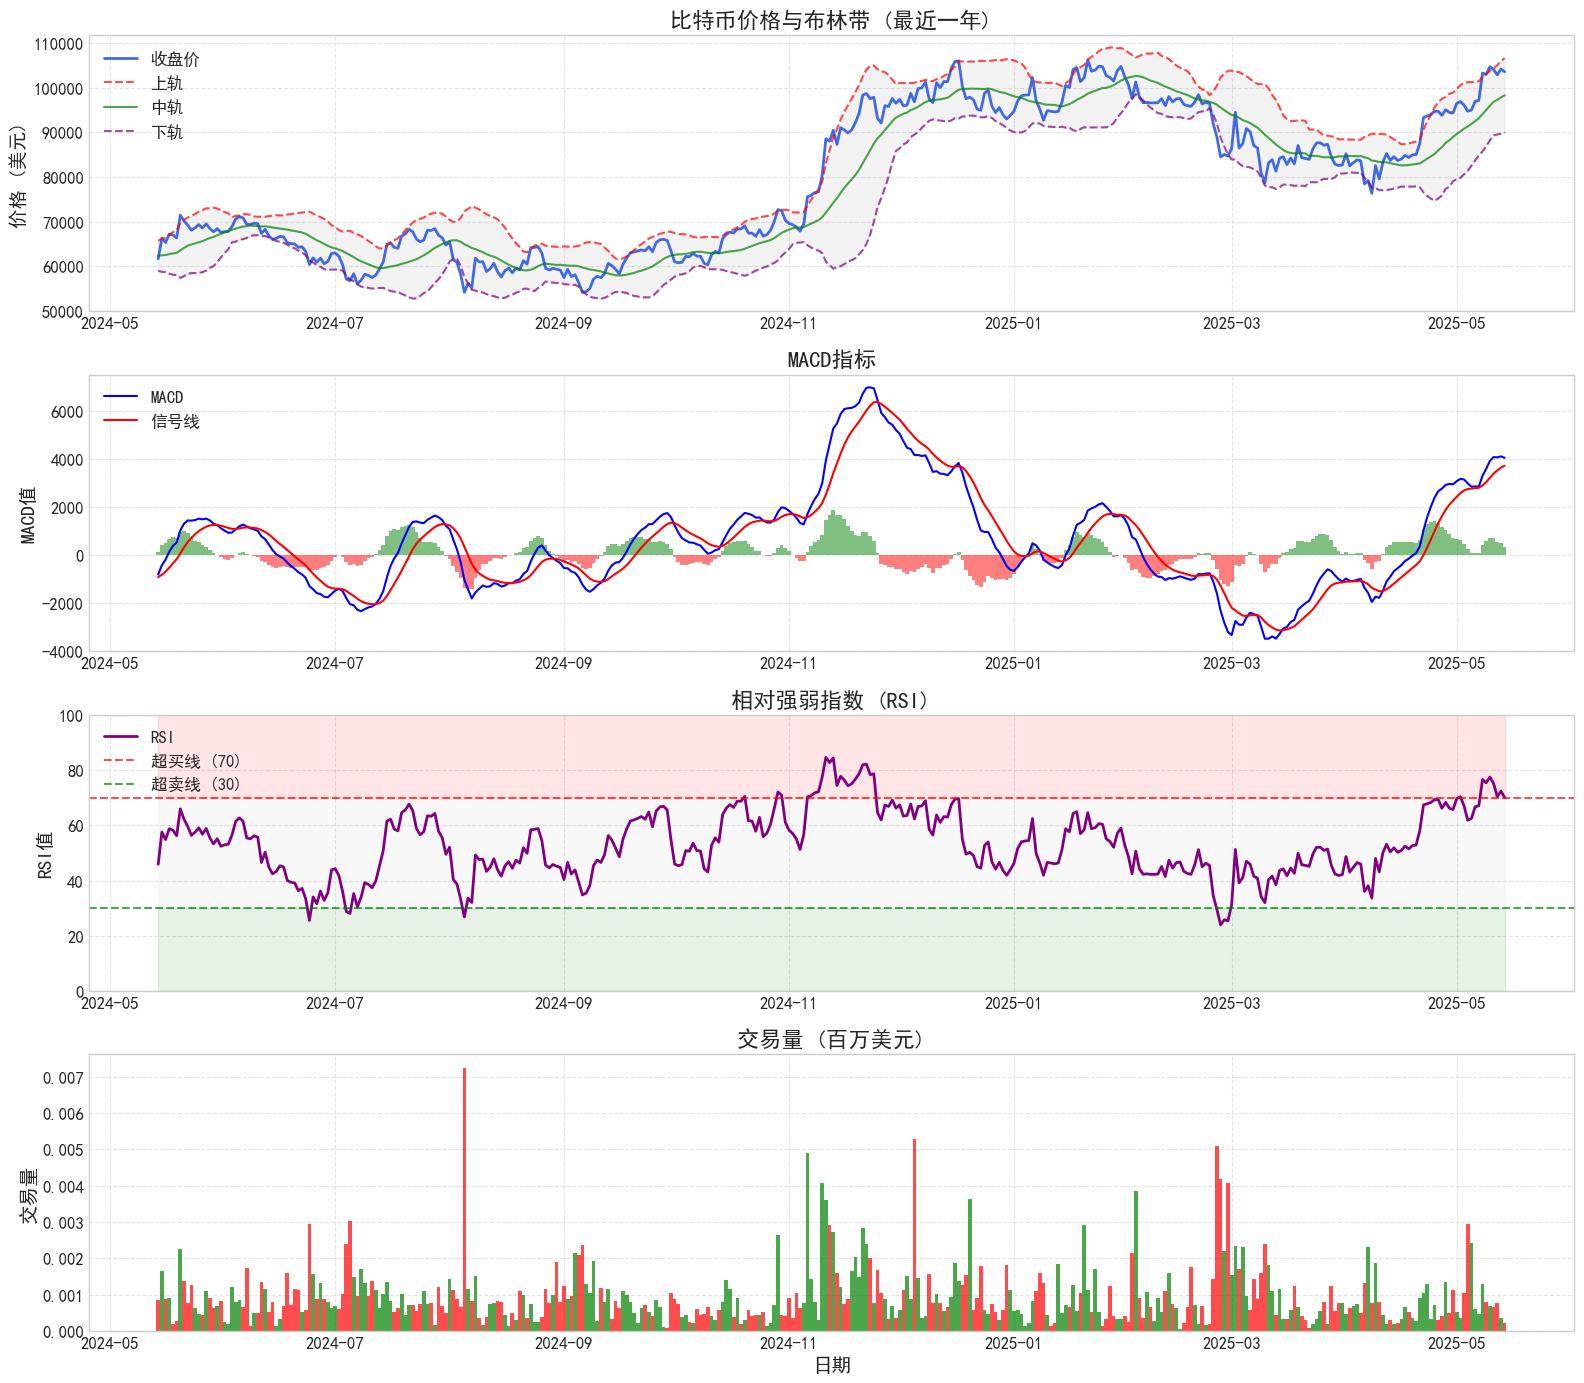

In [39]:

# 图表6: 关键技术指标综合分析 (最近一年)
plt.figure(figsize=(16, 14))
recent_year = df[df.index >= df.index.max() - pd.DateOffset(years=1)]

# 价格和布林带
ax1 = plt.subplot(4, 1, 1)
plt.plot(recent_year.index, recent_year['收盘'], label='收盘价', color='royalblue', linewidth=2)
plt.plot(recent_year.index, recent_year['上轨'], label='上轨', color='red', linestyle='--', alpha=0.7)
plt.plot(recent_year.index, recent_year['中轨'], label='中轨', color='green', linestyle='-', alpha=0.7)
plt.plot(recent_year.index, recent_year['下轨'], label='下轨', color='purple', linestyle='--', alpha=0.7)
plt.fill_between(recent_year.index, recent_year['上轨'], recent_year['下轨'], color='gray', alpha=0.1)
plt.title('比特币价格与布林带 (最近一年)', fontsize=16)
plt.ylabel('价格 (美元)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# MACD指标
ax2 = plt.subplot(4, 1, 2, sharex=ax1)
plt.plot(recent_year.index, recent_year['MACD'], label='MACD', color='blue', linewidth=1.5)
plt.plot(recent_year.index, recent_year['信号线'], label='信号线', color='red', linewidth=1.5)
# 用柱状图表示MACD直方图，红色表示负值，绿色表示正值
plt.bar(recent_year.index, recent_year['MACD_Hist'], 
        color=np.where(recent_year['MACD_Hist'] < 0, 'red', 'green'), 
        alpha=0.5, width=1)
plt.title('MACD指标', fontsize=16)
plt.ylabel('MACD值', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# RSI指标
ax3 = plt.subplot(4, 1, 3, sharex=ax1)
plt.plot(recent_year.index, recent_year['RSI'], label='RSI', color='purple', linewidth=2)
plt.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='超买线 (70)')
plt.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='超卖线 (30)')
plt.fill_between(recent_year.index, 70, 100, color='red', alpha=0.1)
plt.fill_between(recent_year.index, 0, 30, color='green', alpha=0.1)
plt.fill_between(recent_year.index, 30, 70, color='gray', alpha=0.05)
plt.title('相对强弱指数 (RSI)', fontsize=16)
plt.ylabel('RSI值', fontsize=14)
plt.ylim(0, 100)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# 交易量
ax4 = plt.subplot(4, 1, 4, sharex=ax1)
plt.bar(recent_year.index, recent_year['交易量']/1e6, 
        color=np.where(recent_year['收盘'] > recent_year['开盘'], 'green', 'red'), 
        alpha=0.7, width=1)
plt.title('交易量 (百万美元)', fontsize=16)
plt.ylabel('交易量', fontsize=14)
plt.xlabel('日期', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
print("图表6: 关键技术指标综合分析 (最近一年)")
plt.show()


图表7: 预测误差分布分析


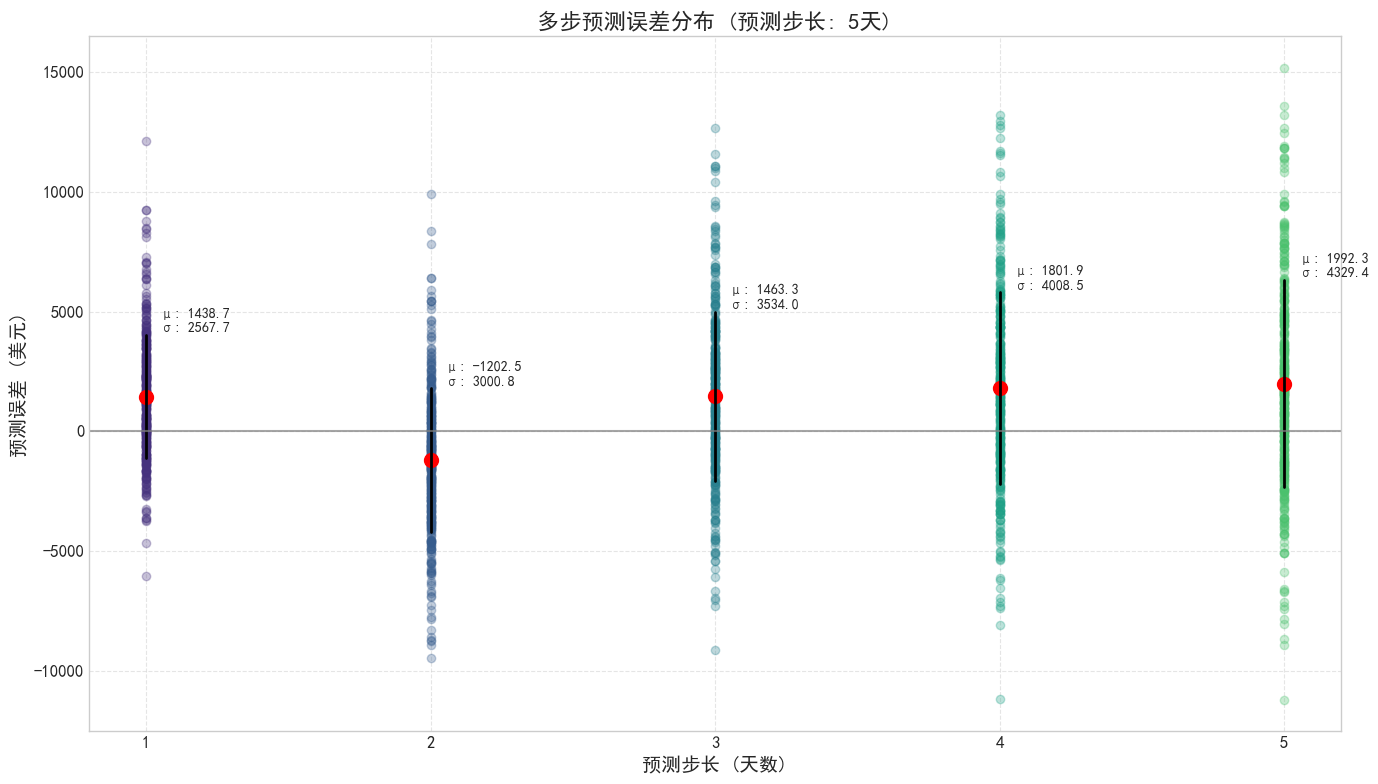

In [40]:
# 图表7: 预测误差分布分析
plt.figure(figsize=(14, 8))

# 计算每一步预测的误差
errors = []
for step in range(forecast_steps):
    step_errors = y_test_orig[:, step] - test_predict_orig[:, step]
    errors.append(step_errors)
    plt.plot([step+1]*len(step_errors), step_errors, 'o', alpha=0.3, markersize=6)

# 添加误差统计
for step in range(forecast_steps):
    step_errors = errors[step]
    mean_err = np.mean(step_errors)
    std_err = np.std(step_errors)
    plt.plot(step+1, mean_err, 'ro', markersize=10)
    plt.plot([step+1, step+1], [mean_err - std_err, mean_err + std_err], 'k-', linewidth=2)
    plt.text(step+1.05, mean_err + std_err + 50, f'μ: {mean_err:.1f}\nσ: {std_err:.1f}', 
             fontsize=10, verticalalignment='bottom')

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.7)
plt.title(f'多步预测误差分布 (预测步长: {forecast_steps}天)', fontsize=16)
plt.xlabel('预测步长 (天数)', fontsize=14)
plt.ylabel('预测误差 (美元)', fontsize=14)
plt.xticks(range(1, forecast_steps+1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
print("图表7: 预测误差分布分析")
plt.show()

图表8: 波动性特征关联性分析


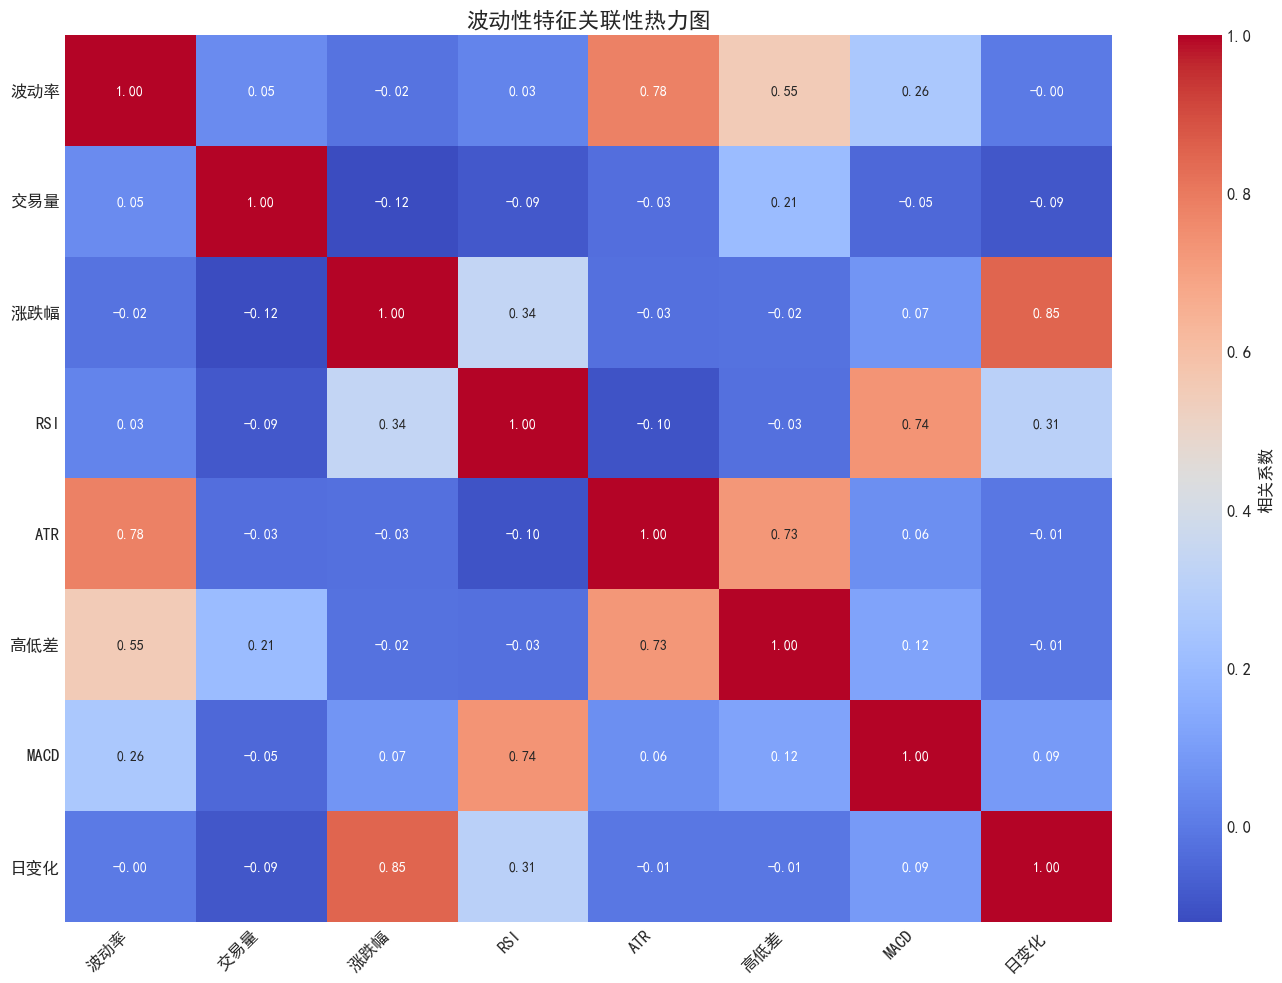

In [41]:
# 图表8: 波动性特征关联性分析
plt.figure(figsize=(14, 10))

# 选择关键特征
features_to_analyze = ['波动率', '交易量', '涨跌幅', 'RSI', 'ATR', '高低差', 'MACD', '日变化']
corr_df = df[features_to_analyze].corr()

# 创建热力图
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', 
            annot_kws={'size': 10}, cbar_kws={'label': '相关系数'})

plt.title('波动性特征关联性热力图', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
print("图表8: 波动性特征关联性分析")
plt.show()

图表9: 高波动区间与市场情绪分析


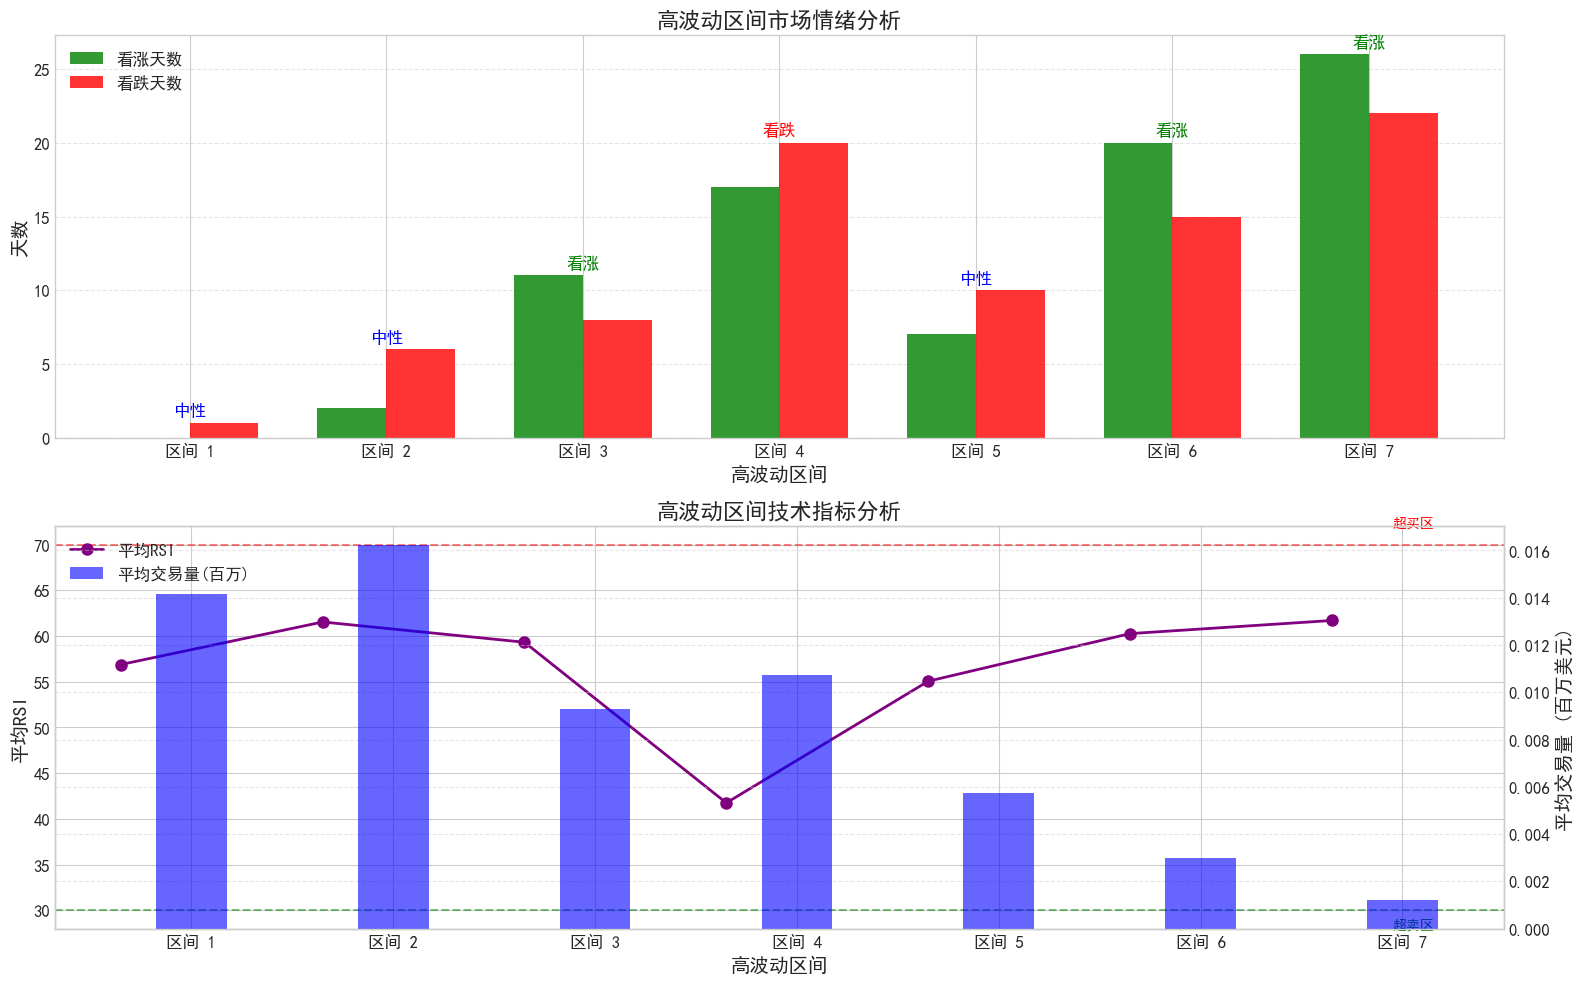

In [42]:
# 图表9: 高波动区间与市场情绪分析
if not volatility_df.empty:
    plt.figure(figsize=(16, 10))
    
    # 创建情绪分析数据
    sentiment_data = []
    for i, row in volatility_df.iterrows():
        start = pd.to_datetime(row['开始日期'])
        end = pd.to_datetime(row['结束日期'])
        vol_data = df.loc[start:end]
        
        # 计算情绪指标
        up_days = (vol_data['收盘'] > vol_data['开盘']).sum()
        down_days = (vol_data['收盘'] < vol_data['开盘']).sum()
        avg_rsi = vol_data['RSI'].mean()
        avg_volume = vol_data['交易量'].mean()
        
        # 确定主导情绪
        if up_days > down_days and avg_rsi > 55:
            sentiment = "看涨"
        elif down_days > up_days and avg_rsi < 45:
            sentiment = "看跌"
        else:
            sentiment = "中性"
        
        sentiment_data.append({
            '区间': f"区间 {i+1}",
            '看涨天数': up_days,
            '看跌天数': down_days,
            '平均RSI': avg_rsi,
            '平均交易量': avg_volume,
            '市场情绪': sentiment
        })
    
    sentiment_df = pd.DataFrame(sentiment_data)
    
    # 创建子图
    plt.subplot(2, 1, 1)
    bar_width = 0.35
    index = np.arange(len(sentiment_df))
    
    plt.bar(index, sentiment_df['看涨天数'], bar_width, label='看涨天数', color='green', alpha=0.8)
    plt.bar(index + bar_width, sentiment_df['看跌天数'], bar_width, label='看跌天数', color='red', alpha=0.8)
    
    plt.xlabel('高波动区间', fontsize=14)
    plt.ylabel('天数', fontsize=14)
    plt.title('高波动区间市场情绪分析', fontsize=16)
    plt.xticks(index + bar_width/2, sentiment_df['区间'])
    plt.legend()
    
    # 添加市场情绪标签
    for i, row in sentiment_df.iterrows():
        plt.text(i + bar_width/2, max(row['看涨天数'], row['看跌天数']) + 0.5, 
                 row['市场情绪'], ha='center', fontsize=12, fontweight='bold',
                 color='green' if row['市场情绪'] == '看涨' else 'red' if row['市场情绪'] == '看跌' else 'blue')
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # RSI和交易量分析
    plt.subplot(2, 1, 2)
    ax = plt.gca()
    ax2 = ax.twinx()
    
    # RSI线图
    line_rsi = ax.plot(index, sentiment_df['平均RSI'], 'o-', color='purple', 
                      markersize=8, linewidth=2, label='平均RSI')
    
    # 交易量柱状图
    bars_volume = ax2.bar(index + bar_width, sentiment_df['平均交易量']/1e6, 
                         bar_width, color='blue', alpha=0.6, label='平均交易量(百万)')
    
    # 添加标签和标题
    ax.set_xlabel('高波动区间', fontsize=14)
    ax.set_ylabel('平均RSI', fontsize=14)
    ax2.set_ylabel('平均交易量 (百万美元)', fontsize=14)
    plt.title('高波动区间技术指标分析', fontsize=16)
    plt.xticks(index + bar_width, sentiment_df['区间'])
    
    # 添加RSI水平线
    ax.axhline(y=70, color='red', linestyle='--', alpha=0.5)
    ax.axhline(y=30, color='green', linestyle='--', alpha=0.5)
    ax.text(len(sentiment_df)-0.7, 72, '超买区', color='red', fontsize=10)
    ax.text(len(sentiment_df)-0.7, 28, '超卖区', color='green', fontsize=10)
    
    # 组合图例
    lines = line_rsi
    labels = [l.get_label() for l in lines]
    bars = [bars_volume]
    bar_labels = [b.get_label() for b in bars]
    ax.legend(lines + bars, labels + bar_labels, loc='upper left')
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    print("图表9: 高波动区间与市场情绪分析")
    plt.show()



图表10: 未来价格预测概率分布


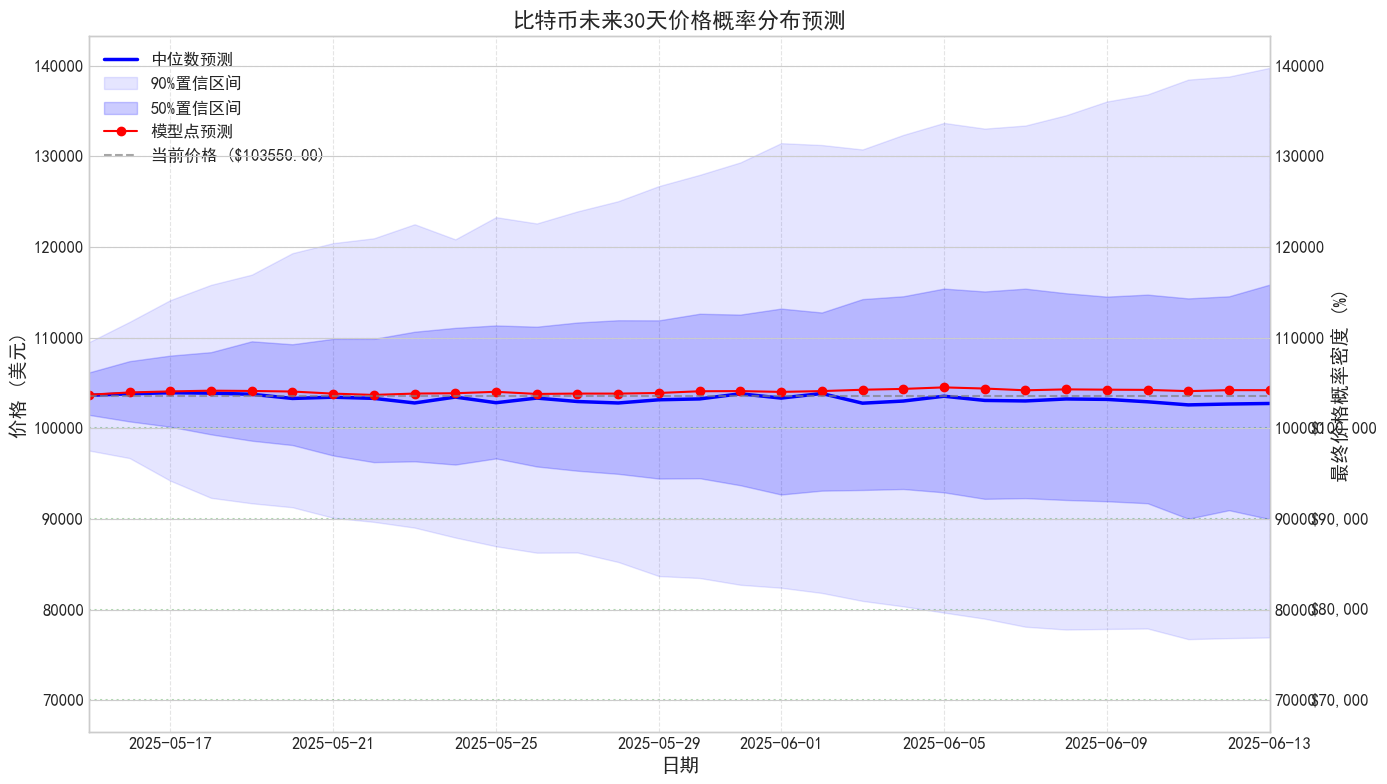

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 图表10: 未来价格预测概率分布
plt.figure(figsize=(14, 8))

# 使用蒙特卡洛方法生成未来价格路径
n_simulations = 500
prediction_days = 30
last_price = df['收盘'].iloc[-1]
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=prediction_days, freq='D')

# 基于历史波动率生成模拟路径
simulations = np.zeros((n_simulations, prediction_days))
daily_volatility = df['收盘'].pct_change().std()

for i in range(n_simulations):
    price_path = [last_price]
    for day in range(prediction_days):
        # 随机收益率基于历史波动率
        ret = np.random.normal(0, daily_volatility)
        new_price = price_path[-1] * (1 + ret)
        price_path.append(new_price)
    simulations[i] = price_path[1:]

# 计算分位数
percentiles = np.percentile(simulations, [5, 25, 50, 75, 95], axis=0)

# 绘制预测路径
plt.plot(future_dates, percentiles[2], 'b-', label='中位数预测', linewidth=2.5)
plt.fill_between(future_dates, percentiles[0], percentiles[4], 
                 color='blue', alpha=0.1, label='90%置信区间')
plt.fill_between(future_dates, percentiles[1], percentiles[3], 
                 color='blue', alpha=0.2, label='50%置信区间')

# 添加点预测
future_predictions = np.mean(simulations, axis=0)
plt.plot(future_dates, future_predictions, 'ro-', label='模型点预测', markersize=6)

# 添加当前价格线
plt.axhline(y=last_price, color='gray', linestyle='--', 
            alpha=0.7, label=f'当前价格 (${last_price:.2f})')

# 添加关键价格水平
for price_level in [50000, 60000, 70000, 80000, 90000, 100000]:
    if price_level > min(percentiles[0])*0.9 and price_level < max(percentiles[4])*1.1:
        plt.axhline(y=price_level, color='green', linestyle=':', alpha=0.3)
        plt.text(future_dates[-1] + pd.Timedelta(days=1), price_level, 
                 f'${price_level:,.0f}', verticalalignment='center')

plt.title('比特币未来30天价格概率分布预测', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('价格 (美元)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# 添加概率密度注释
final_prices = simulations[:, -1]
price_bins = np.linspace(min(final_prices)*0.9, max(final_prices)*1.1, 20)
price_probs = np.histogram(final_prices, bins=price_bins, density=True)[0]
price_probs = price_probs / price_probs.sum() * 100

# 在右侧添加概率密度图
ax = plt.gca()
ax2 = ax.twinx()
ax2.barh(price_bins[:-1], price_probs, height=np.diff(price_bins), 
         align='edge', alpha=0.2, color='purple')
ax2.set_ylabel('最终价格概率密度 (%)', fontsize=14)
ax2.set_ylim(ax.get_ylim())

# 限制横坐标范围
plt.xlim(future_dates[0], future_dates[-1])

plt.tight_layout()
print("图表10: 未来价格预测概率分布")
plt.show()

In [32]:
# 输出模型评估结果
print(f"\n模型评估结果:")
print(f"测试集RMSE: ${test_rmse:.2f}")
print(f"测试集MAPE: {test_mape:.2f}%")
print(f"未来30天预测价格范围: ${min(future_predictions):.2f} - ${max(future_predictions):.2f}")
print(f"预测趋势: {'上涨' if future_predictions[-1] > future_predictions[0] else '下跌'}, "
      f"变化幅度: {abs((future_predictions[-1] - future_predictions[0])/future_predictions[0]*100):.1f}%")


模型评估结果:
测试集RMSE: $2943.29
测试集MAPE: 2.77%
未来30天预测价格范围: $99717.28 - $105354.01
预测趋势: 上涨, 变化幅度: 4.1%
